# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [12]:
# Jedi Not Working
 %config Completer.use_jedi = False

In [15]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [16]:

# env = UnityEnvironment(file_name='envs/Reacher_Windows_x86_64-one-agent/Reacher.exe')
env = UnityEnvironment(file_name='envs/Reacher_Windows_x86_64-twenty-agents/Reacher.exe')

OSError: handle is closed

ERROR:root:Exception calling application: [WinError 232] The pipe is being closed
Traceback (most recent call last):
  File "D:\ProgramData\miniconda3\envs\drlnd\lib\site-packages\grpc\_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "D:\ProgramData\miniconda3\envs\drlnd\lib\site-packages\unityagents\rpc_communicator.py", line 25, in Exchange
    self.child_conn.send(request)
  File "D:\ProgramData\miniconda3\envs\drlnd\lib\multiprocessing\connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "D:\ProgramData\miniconda3\envs\drlnd\lib\multiprocessing\connection.py", line 280, in _send_bytes
    ov, err = _winapi.WriteFile(self._handle, buf, overlapped=True)
BrokenPipeError: [WinError 232] The pipe is being closed


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print(f'There are {states.shape[0]} agents. Each observes a state with '
      f'length: {state_size}')
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

KeyboardInterrupt: 

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

## 4.1 DDPG

### Model Architecture + Init
...

### Training

In [1]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from reacher_agents.ddpg_agent import DDPGAgent
from reacher_agents.trainers import MultiAgentTrainer, SingleAgentTrainer

from reacher_agents.config import (
    ENV_TYPE,
    CLOUD,
    BUFFER_SIZE,
    BATCH_SIZE,
    N_EPISODES,
    MAX_T,
    N_WORKERS,
    MAX_WORKERS,
    LEARN_F,
    GAMMA,
    TAU,
    LR_ACTOR,
    LR_CRITIC,
    WEIGHT_DECAY,
    WINDOW_LEN,
)

#### Import

In [2]:
if CLOUD:
    !pip -q install ./python

if ENV_TYPE.lower() == 'gym':
    import gym
    from reacher_agents.gym_environments import GymContinuousEnvMgr
#     scenarios = {'LunarLanderContinuous-v2',
#                  'BipedalWalker-v3',
#                  'Pendulum-v0'}
    envh = GymContinuousEnvMgr('Pendulum-v0')
    root_name = 'gym'
    Trainer = SingleAgentTrainer
    upper_bound = 2.0
    solved = -250
else:
    from reacher_agents.unity_environments import UnityEnvMgr
    if N_WORKERS == 1:
        file_name = 'envs/Reacher_Windows_x86_64-one-agent/Reacher.exe'
        root_name = 'multi'
    else:
        file_name = 'envs/Reacher_Windows_x86_64-twenty-agents/Reacher.exe'
        root_name = 'single'
    envh = UnityEnvMgr(file_name)
    Trainer = MultiAgentTrainer
    upper_bound = 1.0
    solved = 30.0
    
if CLOUD:
    if one_agent:
        file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64'
    else:
        file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64'
    envh = UnityEnvMgr(file_name)

In [3]:
env = envh.start()
state_size = envh.state_size
action_size = envh.action_size
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
agent = DDPGAgent(
    state_size=state_size,
    action_size=action_size,
    buffer_size=BUFFER_SIZE,
    batch_size=BATCH_SIZE,
    gamma=GAMMA,
    tau=TAU,
    lr_actor=LR_ACTOR,
    lr_critic=LR_CRITIC,
    learn_f=LEARN_F,
    weight_decay=WEIGHT_DECAY,
    device=device,
    random_seed=42,
    upper_bound=upper_bound,
)
trainer = Trainer(
    agent=agent,
    env=envh,
    n_episodes=N_EPISODES,
    max_t=MAX_T,
    window_len=WINDOW_LEN,
    solved=solved,
    n_workers=N_WORKERS,
    max_workers=MAX_WORKERS,  # note can be lower than n
    save_root=root_name,
)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Train

In [ ]:
scores = trainer.train()

Episode 19	Average Score: 0.29

In [27]:
env.close()

### Visualize

In [21]:
np.mean(np.array(trainer.scores_).squeeze(), 1).shape

(300,)

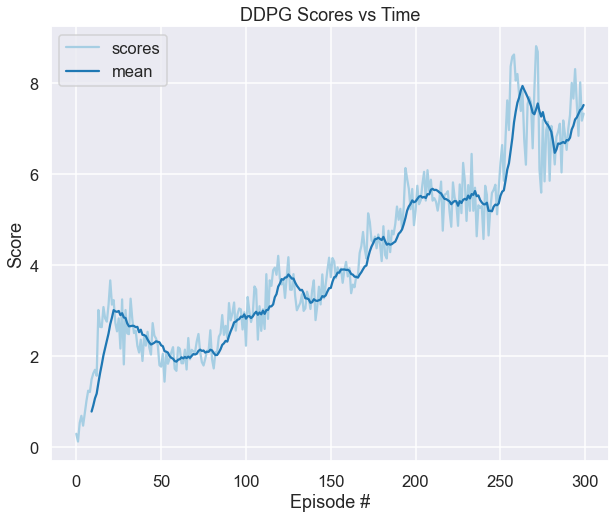

In [22]:
sns.set_style('darkgrid')
sns.set_context('talk')
sns.set_palette('Paired')
cmap = sns.color_palette('Paired')
i_map = 0

scores = np.mean(np.array(trainer.scores_).squeeze(), 1)
score_df = pd.DataFrame({'scores': scores})
score_df = score_df.assign(mean=lambda df: df.rolling(10).mean()['scores'])

fig ,ax = plt.subplots(1,1, figsize=(10,8))

ax = score_df.plot(ax=ax, color=cmap[2*(i_map%3):])
ax.set_title('DDPG Scores vs Time')
ax.set_xlabel('Episode #')
ax.set_ylabel('Score')
plt.show()

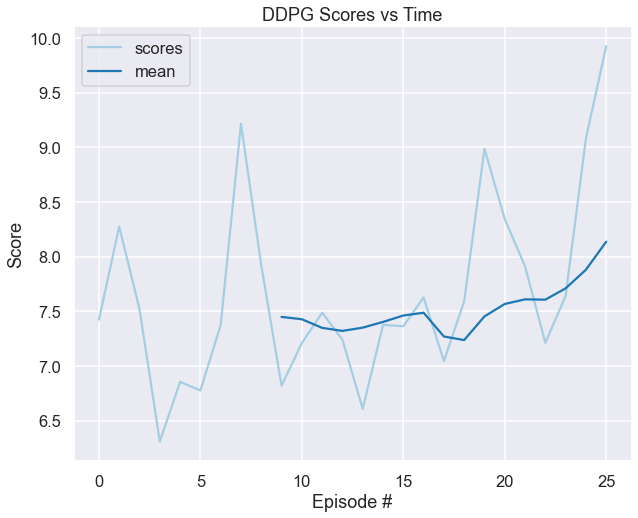

In [26]:
sns.set_style('darkgrid')
sns.set_context('talk')
sns.set_palette('Paired')
cmap = sns.color_palette('Paired')
i_map = 0

scores = np.mean(np.array(trainer.scores_).squeeze(), 1)
score_df = pd.DataFrame({'scores': scores})
score_df = score_df.assign(mean=lambda df: df.rolling(10).mean()['scores'])

fig ,ax = plt.subplots(1,1, figsize=(10,8))

ax = score_df.plot(ax=ax, color=cmap[2*(i_map%3):])
ax.set_title('DDPG Scores vs Time')
ax.set_xlabel('Episode #')
ax.set_ylabel('Score')
plt.show()

### Evaluation

In [5]:
agent.load(
    r'D:\udacity\deep-rl\projects\p2_reacher\cont-control\gym-solved-20210910T174534_actor.pth',
    r'D:\udacity\deep-rl\projects\p2_reacher\cont-control\gym-solved-20210910T174534_critic.pth',
)
trainer = Trainer(
    agent=agent,
    env=envh,
    n_workers=N_WORKERS,
)

In [7]:
scores = trainer.eval(n_episodes=100, render=False)

Episode 100	Final Score: -213.80

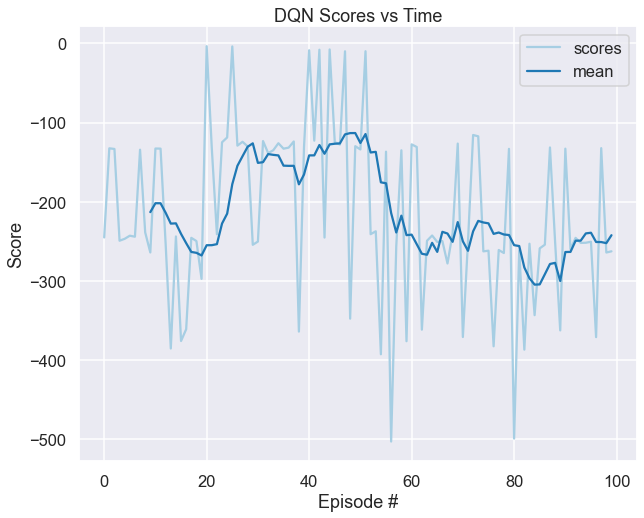

In [8]:
sns.set_style('darkgrid')
sns.set_context('talk')
sns.set_palette('Paired')
cmap = sns.color_palette('Paired')
i_map = 0

scores = np.array(trainer.scores_).squeeze()
score_df = pd.DataFrame({'scores': scores})
score_df = score_df.assign(mean=lambda df: df.rolling(10).mean()['scores'])

fig ,ax = plt.subplots(1,1, figsize=(10,8))

ax = score_df.plot(ax=ax, color=cmap[2*(i_map%3):])
ax.set_title('DDPG Scores vs Time')
ax.set_xlabel('Episode #')
ax.set_ylabel('Score')
plt.show()